In [1]:
import sys
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get the absolute path to the src directory
sys.path.append(os.path.abspath("../src"))
# Now you can import preprocessor
from preprocessor import LLMTIMEPreprocessor
from generate_predictions import PredictionPipeline, TrajectoryDataset


In [2]:
file_path = "../lotka_volterra_data.h5"

with h5py.File(file_path, "r") as f:
    trajectories = f["trajectories"][:]  # Shape: (1000, 100, 2)
    time_points = f["time"][:]  # Shape: (100,)

# Convert to Pandas DataFrame for visualization
num_samples = 1000  
data_dict = {
    "Time": np.tile(time_points, num_samples),
    "Prey Population": trajectories[:num_samples, :, 0].flatten(),
    "Predator Population": trajectories[:num_samples, :, 1].flatten(),
    "Sample ID": np.repeat(range(num_samples), len(time_points)),
}

df = pd.DataFrame(data_dict)

In [3]:
df.shape

(100000, 4)

In [4]:
df.head()

,Time,Prey Population,Predator Population,Sample ID
0,0.000000,0.949917,1.040624,0
1,2.020202,0.740551,0.779542,0
2,4.040404,0.682246,0.564390,0
3,6.060606,0.716674,0.407644,0
4,8.080808,0.824511,0.300283,0


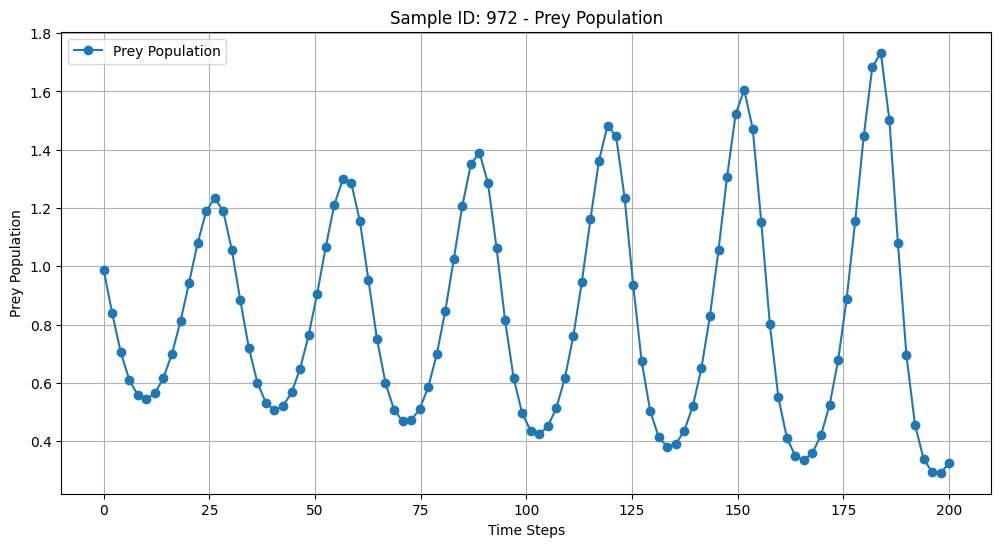

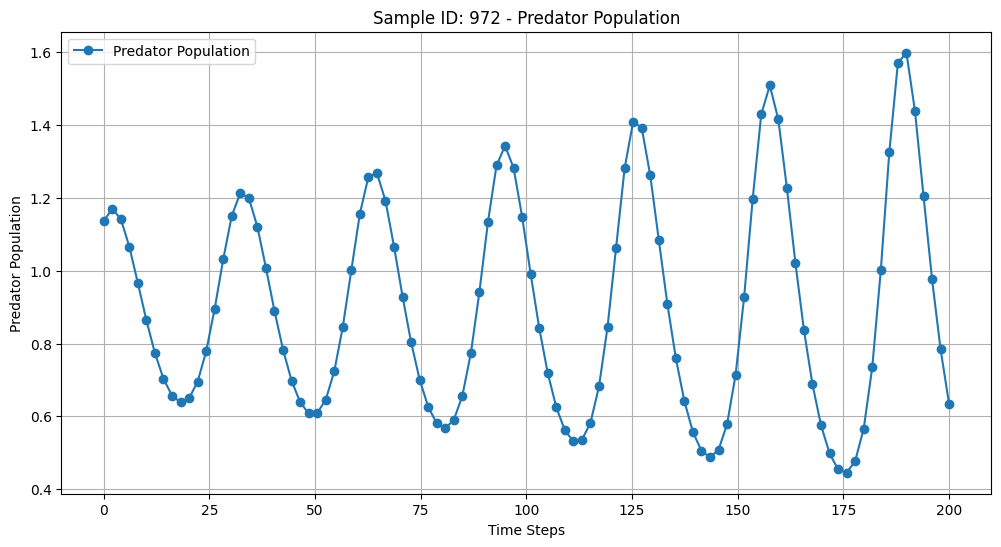

In [5]:
import matplotlib.pyplot as plt

sample_id = 972
sample_data = df[df['Sample ID'] == sample_id]

# Extract time, prey population, and predator population
time = sample_data['Time'].values
prey_population = sample_data['Prey Population'].values
predator_population = sample_data['Predator Population'].values

# Plot the true values for prey population
plt.figure(figsize=(12, 6))
plt.plot(time, prey_population, label='Prey Population', marker='o')
plt.title(f'Sample ID: {sample_id} - Prey Population')
plt.xlabel('Time Steps')
plt.ylabel('Prey Population')
plt.legend()
plt.grid(True)
plt.show()

# Plot the true values for predator population
plt.figure(figsize=(12, 6))
plt.plot(time, predator_population, label='Predator Population', marker='o')
plt.title(f'Sample ID: {sample_id} - Predator Population')
plt.xlabel('Time Steps')
plt.ylabel('Predator Population')
plt.legend()
plt.grid(True)
plt.show()

/Users/raunaqrai/miniconda_x86_64/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/Users/raunaqrai/miniconda_x86_64/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


>>> Padding side in tokenize_input: left


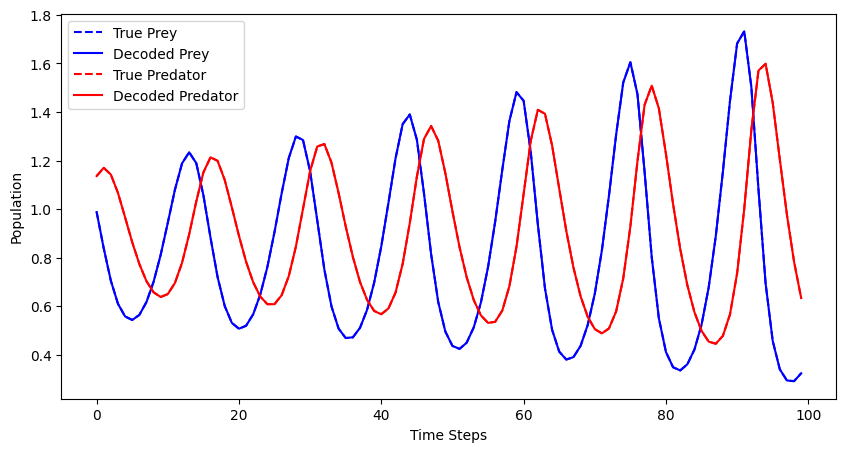


Evaluation Metrics:
   MSE: 0.0000
   MAE: 0.0004
   R² Score: 1.0000


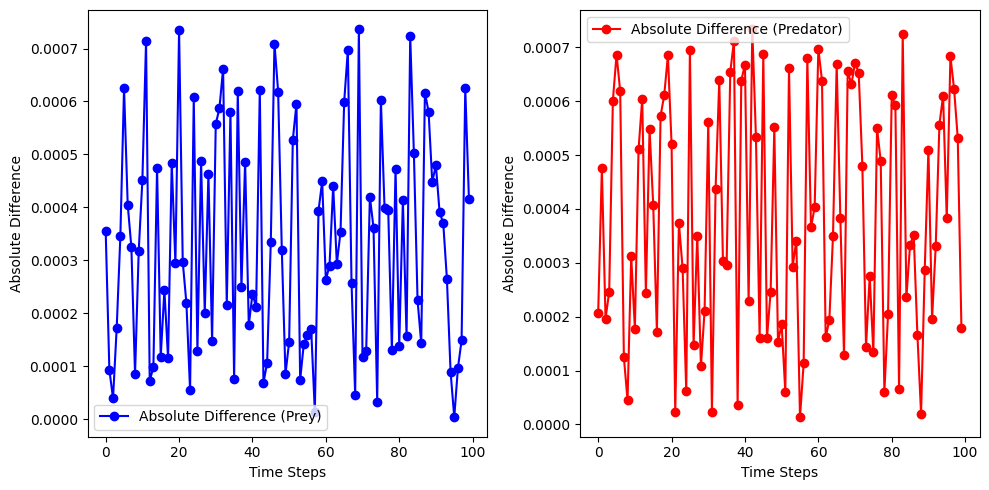

Mean Squared Error (Prey): 0.000000
Mean Squared Error (Predator): 0.000000


In [6]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import os
import h5py
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sys.path.append(os.path.abspath("../src"))

from load_qwen import load_qwen_model
from preprocessor import LLMTIMEPreprocessor

# Load the model and tokenizer
model, tokenizer = load_qwen_model()

# Set the model to evaluation mode
model.eval()

# Initialize preprocessor
preprocessor = LLMTIMEPreprocessor()

# Load the true data from the HDF5 file
file_path = "../lotka_volterra_data.h5"
with h5py.File(file_path, "r") as f:
    trajectories = f["trajectories"][:]
    time_points = f["time"][:]

# Select a sample index and number of steps
sample_index = 972
num_steps = 100

# Extract prey and predator data for the selected sample
prey = trajectories[sample_index, :num_steps, 0]
predator = trajectories[sample_index, :num_steps, 1]

# Preprocess data (tokenize the input)
formatted_text, tokenized_seq, scale_factor = preprocessor.preprocess_sample(prey, predator, num_steps)

# Decode tokens back to text
decoded_text = tokenizer.decode(tokenized_seq[0], skip_special_tokens=True)

# Parse the decoded text back into numerical values
decoded_pairs = [list(map(float, pair.split(','))) for pair in decoded_text.split(';') if ',' in pair]
decoded_prey, decoded_predator = zip(*decoded_pairs) if decoded_pairs else ([], [])

# Scale back to original values
decoded_prey = np.array(decoded_prey) * scale_factor
decoded_predator = np.array(decoded_predator) * scale_factor

# Plot the true vs decoded values
plt.figure(figsize=(10, 5))
plt.plot(prey, label="True Prey", linestyle='dashed', color='blue')
plt.plot(decoded_prey, label="Decoded Prey", linestyle='solid', color='blue')

plt.plot(predator, label="True Predator", linestyle='dashed', color='red')
plt.plot(decoded_predator, label="Decoded Predator", linestyle='solid', color='red')

plt.xlabel("Time Steps")
plt.ylabel("Population")
plt.legend()
plt.savefig("true_vs_decoded.png")
plt.show()

# Calculate evaluation metrics
true_values = np.concatenate((prey, predator))
decoded_values = np.concatenate((decoded_prey, decoded_predator))

mse = mean_squared_error(true_values, decoded_values)
mae = mean_absolute_error(true_values, decoded_values)
r2 = r2_score(true_values, decoded_values)

print("\nEvaluation Metrics:")
print(f"   MSE: {mse:.4f}")
print(f"   MAE: {mae:.4f}")
print(f"   R² Score: {r2:.4f}")

# Plot the absolute differences
abs_diff_prey = np.abs(prey - decoded_prey)
abs_diff_predator = np.abs(predator - decoded_predator)

plt.figure(figsize=(10, 5))

# Prey absolute difference plot
plt.subplot(1, 2, 1)
plt.plot(abs_diff_prey, label="Absolute Difference (Prey)", color='blue', marker='o')
plt.xlabel("Time Steps")
plt.ylabel("Absolute Difference")
plt.legend()

# Predator absolute difference plot
plt.subplot(1, 2, 2)
plt.plot(abs_diff_predator, label="Absolute Difference (Predator)", color='red', marker='o')
plt.xlabel("Time Steps")
plt.ylabel("Absolute Difference")
plt.legend()

plt.tight_layout()
plt.savefig("absolute_differences.png")
plt.show()

mse_prey = mean_squared_error(prey, decoded_prey)
mse_predator = mean_squared_error(predator, decoded_predator)

# Print MSE values
print(f"Mean Squared Error (Prey): {mse_prey:.6f}")
print(f"Mean Squared Error (Predator): {mse_predator:.6f}")

/Users/raunaqrai/miniconda_x86_64/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Input token count: 499
Generated tokens: 540


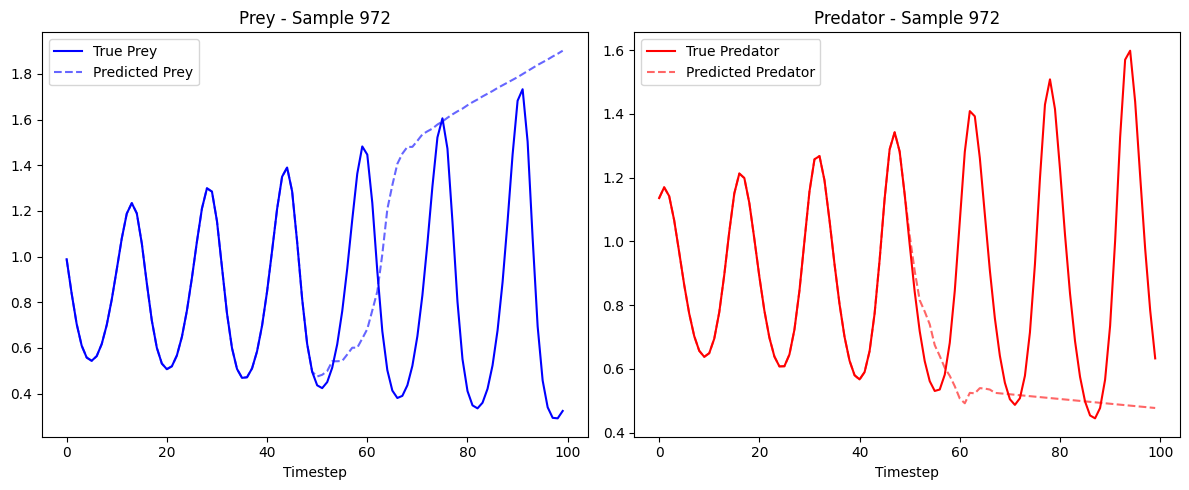


Evaluation Metrics for Sample ID 972
Prey:
  MSE: 0.3812
  MAE: 0.3597
  R²: -1.7590
Predator:
  MSE: 0.1324
  MAE: 0.1904
  R²: -0.4884


In [ ]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sys.path.append(os.path.abspath("../src"))
from preprocessor import LLMTIMEPreprocessor
from load_qwen import load_qwen_model

# Load model and tokenizer
model, tokenizer = load_qwen_model()
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
model.eval()
preprocessor = LLMTIMEPreprocessor()

with h5py.File("../lotka_volterra_data.h5", "r") as f:
    data = f["trajectories"][:]  

# Convert to long-form DataFrame with Sample ID
records = []
for i in range(data.shape[0]):
    for t in range(100):
        records.append({
            "Sample ID": i,
            "Timestep": t,
            "Prey Population": data[i, t, 0],
            "Predator Population": data[i, t, 1]
        })

df = pd.DataFrame(records)

def baseline_model_testing(data, test_fraction=0.5, sample_ids=[972]):
    predictions = {}
    input_timesteps = int(test_fraction * 100)
    output_timesteps = 100 - input_timesteps

    for sample_id in sample_ids:
        sample_data = data[data['Sample ID'] == sample_id]
        prey = sample_data['Prey Population'].values
        predator = sample_data['Predator Population'].values

        input_text, tokenized_input, scale_factor = preprocessor.preprocess_sample(prey, predator, input_timesteps)
        tokens = tokenized_input.to(device)

        # Initial generation
        token_preds = model.generate(tokens, max_new_tokens=int(output_timesteps * 10))
    

        # Continue if needed
        semicolons = (token_preds[0] == tokenizer.convert_tokens_to_ids(';')).nonzero(as_tuple=True)[0]
        while len(semicolons) < 100 and len(token_preds[0]) < 2000:
            token_preds = model.generate(token_preds, max_new_tokens=20)
            semicolons = (token_preds[0] == tokenizer.convert_tokens_to_ids(';')).nonzero(as_tuple=True)[0]

        # Cut at 100 steps
        if len(semicolons) >= 100:
            tokens_1d = token_preds[0][:semicolons[99] + 1]
        else:
            tokens_1d = token_preds[0]

        decoded = tokenizer.decode(tokens_1d, skip_special_tokens=True)
        decoded_pairs = [list(map(float, pair.split(','))) for pair in decoded.split(';') if ',' in pair]
        decoded_prey, decoded_predator = zip(*decoded_pairs) if decoded_pairs else ([], [])

        predictions[sample_id] = {
            "prey": np.array(decoded_prey) * scale_factor,
            "predator": np.array(decoded_predator) * scale_factor
        }

        input_token_count = tokenized_input.shape[1]
        print(f"Input token count: {input_token_count}")

        generated_token_count = token_preds.shape[1] - tokens.shape[1]
        print(f"Generated tokens: {generated_token_count}")

    return predictions

# Get predictions for just Sample ID 972
predictions = baseline_model_testing(df, test_fraction=0.5, sample_ids=[972])


def plot_predictions(predictions, original_series, sample_id):
    pred_prey = predictions[sample_id]["prey"]
    pred_predator = predictions[sample_id]["predator"]
    true_prey = original_series[:, 0]
    true_predator = original_series[:, 1]

    timesteps = np.arange(len(true_prey))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(timesteps, true_prey, label='True Prey', color='blue')
    plt.plot(timesteps[:len(pred_prey)], pred_prey, '--', label='Predicted Prey', color='blue', alpha=0.6)
    plt.title(f"Prey - Sample {sample_id}")
    plt.xlabel("Timestep")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(timesteps, true_predator, label='True Predator', color='red')
    plt.plot(timesteps[:len(pred_predator)], pred_predator, '--', label='Predicted Predator', color='red', alpha=0.6)
    plt.title(f"Predator - Sample {sample_id}")
    plt.xlabel("Timestep")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"sample{sample_id}_untrained.png",dpi=300)  
    plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_metrics(predictions, original_series, sample_id):
    """
    Computes MSE, MAE, and R² for predicted vs true values for a specific Sample ID.

    Args:
        predictions (dict): Model output with 'prey' and 'predator' arrays.
        original_series (np.ndarray): Ground truth [100, 2] array for prey and predator.
        sample_id (int): ID used to index into predictions.

    Returns:
        dict: Metrics for prey and predator separately.
    """
    pred_prey = predictions[sample_id]["prey"]
    pred_predator = predictions[sample_id]["predator"]
    true_prey = original_series[:, 0]
    true_predator = original_series[:, 1]

    # Truncate to match length of predictions
    min_len_prey = min(len(pred_prey), len(true_prey))
    min_len_predator = min(len(pred_predator), len(true_predator))

    prey_metrics = {
        "MSE": mean_squared_error(true_prey[:min_len_prey], pred_prey[:min_len_prey]),
        "MAE": mean_absolute_error(true_prey[:min_len_prey], pred_prey[:min_len_prey]),
        "R²":  r2_score(true_prey[:min_len_prey], pred_prey[:min_len_prey]),
    }

    predator_metrics = {
        "MSE": mean_squared_error(true_predator[:min_len_predator], pred_predator[:min_len_predator]),
        "MAE": mean_absolute_error(true_predator[:min_len_predator], pred_predator[:min_len_predator]),
        "R²":  r2_score(true_predator[:min_len_predator], pred_predator[:min_len_predator]),
    }

    print(f"\nEvaluation Metrics for Sample ID {sample_id}")
    print("Prey:")
    for k, v in prey_metrics.items():
        print(f"  {k}: {v:.4f}")
    print("Predator:")
    for k, v in predator_metrics.items():
        print(f"  {k}: {v:.4f}")

    return {"prey": prey_metrics, "predator": predator_metrics}

# Plot sample 972
original_series = df[df['Sample ID'] == 972][['Prey Population', 'Predator Population']].values
plot_predictions(predictions, original_series, sample_id=972)

metrics = evaluate_metrics(predictions, original_series, sample_id=972)

In [9]:
from flops_model import forwards_pass_flops

# Estimate FLOPs per forward pass based on input length
input_token_count = 499
forward_flops, _ = forwards_pass_flops(input_token_count, lora_ranks=0)
flops_per_token = forward_flops.sum().item()  # total for 1 generated token

# Estimate total FLOPs
total_flops = flops_per_token * 520
print(f"Approximate total FLOPs used for generation: {total_flops:.2e}")


Approximate total FLOPs used for generation: 2.85e+14
